In [1]:
import os.path
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = 'multiplex_embeddings_data'
datasets_layer_description = {  # {dataset: [layer_1 description, layer_2 description, ...]}
    'Air_Train': [
        'Air network',
        'Train network',
    ],
    'arXiv': [
        'physics.bioph category',
        'cond-mat.disnn category',
        'physics.soc-ph',
        'physics.data-an category',
        'math.OC category',
        'cond-mat.stat-mech category',
        'q-bio.MN category',
        'cs.SI category',
    ],
    'C. Elegans Connectomme': [
        'Electric',
        'Chemical Monadic',
        'Chemical Polyadic',
    ],
    'Drosophila Melanogaster': [  # meh
        'suppressive genetic interaction',
        'additive genetic interaction',
    ],
    'Human Brain': [
        'structural brain network',
        'functional brain network',
    ],
    'IPv4_IPv6 Internet': [  # meh
        'IPv4 topology',
        'IPv6 topology',
    ],
    'Physicians': [
        'advice',
        'discussion',
        'friendship',
    ],
    'Rattus': [  # meh
        'physical association',
        'direct interaction',
    ],
    'SacchPomb': [
        'direct interaction',
        'colocalization',
        'physical association',
        'synthetic genetic interaction',
        'association',
    ],
}
dataset_names = list(datasets_layer_description.keys())
datasets_layer_description, dataset_names

({'Air_Train': ['Air network', 'Train network'],
  'arXiv': ['physics.bioph category',
   'cond-mat.disnn category',
   'physics.soc-ph',
   'physics.data-an category',
   'math.OC category',
   'cond-mat.stat-mech category',
   'q-bio.MN category',
   'cs.SI category'],
  'C. Elegans Connectomme': ['Electric',
   'Chemical Monadic',
   'Chemical Polyadic'],
  'Drosophila Melanogaster': ['suppressive genetic interaction',
   'additive genetic interaction'],
  'Human Brain': ['structural brain network', 'functional brain network'],
  'IPv4_IPv6 Internet': ['IPv4 topology', 'IPv6 topology'],
  'Physicians': ['advice', 'discussion', 'friendship'],
  'Rattus': ['physical association', 'direct interaction'],
  'SacchPomb': ['direct interaction',
   'colocalization',
   'physical association',
   'synthetic genetic interaction',
   'association']},
 ['Air_Train',
  'arXiv',
  'C. Elegans Connectomme',
  'Drosophila Melanogaster',
  'Human Brain',
  'IPv4_IPv6 Internet',
  'Physicians',
  'Ra

In [3]:
def load_dataset(dataset_name):
    print(f'Loading {dataset_name}')
    path = os.path.join(data_path, dataset_name)
    layer_paths = [os.path.join(path, f'l_{i}.txt')
                  for i in range(1, len(datasets_layer_description[dataset_name]) + 1)]
    G = [nx.read_edgelist(
            layer_path,
            create_using=nx.Graph,
            nodetype=int,
        ) for layer_path in layer_paths]
    print(*G, sep='\n')
    return G

In [37]:
def graph_stats(G):

    possible_nodes = set(G[0].nodes).union(
        *(set(g.nodes) for g in G[1:]),
    )
    outliers = [(n, i)
                for n in possible_nodes
                for i, g in enumerate(G)
                if n not in g]
    if outliers:
        print(f'{len(outliers)} nodes missing from layers: {outliers}')
        print('Fixing naively')

        for i, g in enumerate(G):
            g.add_nodes_from([n for n, il in outliers if il == i])
        
        # Check
        possible_nodes = set(G[0].nodes).union(
            *(set(g.nodes) for g in G[1:]),
        )
        outliers = [(n, i)
                    for n in possible_nodes
                    for i, g in enumerate(G)
                    if n not in g]
        if outliers:
            print(f'Still outliers: {outliers}')

    fig, ax = plt.subplots(nrows=len(G), ncols=3, figsize=(12, 3 * len(G)))
    for i, g in enumerate(G):

        print(f'Layer {i + 1}:')
        print(f'  Size: {len(g)}')
        print(f'  Edges: {len(g.edges)}')

        degree_sequence = sorted((d for _, d in g.degree), reverse=True)
        print(f'  Mean degree: {np.mean(degree_sequence)}')

        sorted_nodes = sorted(g.nodes)
        mn, mx = sorted_nodes[0], sorted_nodes[-1]
        if all(n1 == n2 for n1, n2 in zip(sorted_nodes, range(mn, mx + 1))):
        # if sorted_nodes == list(range(mn, mx + 1)):
            print(f'  Nodes are labeled through {mn}:{mx}')
        else:
            gaps = [n for n in range(mn, mx + 1) if n not in sorted_nodes]
            print(f'  Nodes are labeled through {mn}:{mx} with {len(gaps)} gaps {gaps}')
        
        ax[i, 0].set_title('Degree distribution')
        ax[i, 0].bar(*np.unique(degree_sequence, return_counts=True), width=.8)

        ax[i, 1].set_title('Degree distribution (log)')
        ax[i, 1].hist(degree_sequence, bins=np.logspace(np.log10(1), np.log10(len(g)), num=len(g)), rwidth=.8)
        # ax[i, 1].hist(degree_sequence, bins=len(g), rwidth=.8)
        ax[i, 1].set_xscale('log')
        ax[i, 1].set_yscale('log')
        # ax2.plot(np.exp(np.arange(1, np.log10(len(G)))), 1000 - 2.5 * np.exp(np.arange(1, np.log10(len(G)))))

        if len(g) < 1000:
            ax[i, 2].set_title('Graph')
            # gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
            pos = nx.spring_layout(g, seed=10396953)
            nx.draw_networkx_nodes(g, pos, ax=ax[i, 2], node_size=20)
            nx.draw_networkx_edges(g, pos, ax=ax[i, 2], alpha=.4, arrows=True)
            ax[i, 2].set_axis_off()

    fig.tight_layout()

In [38]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [39]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_g = clusters_in_layers[i]
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [40]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [41]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [42]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

In [52]:
experiment = dataset_names[8]
save_results = False

Loading SacchPomb
Graph with 936 nodes and 1332 edges
Graph with 346 nodes and 370 edges
Graph with 2400 nodes and 6973 edges
Graph with 897 nodes and 2540 edges
Graph with 181 nodes and 218 edges
9310 nodes missing from layers: [(1, 1), (1, 2), (1, 4), (2, 4), (3, 4), (4, 4), (5, 1), (5, 4), (6, 4), (7, 4), (8, 1), (8, 4), (9, 4), (10, 3), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (15, 3), (15, 4), (16, 0), (16, 1), (16, 3), (16, 4), (17, 0), (17, 1), (17, 3), (17, 4), (18, 0), (18, 1), (18, 4), (19, 4), (20, 1), (20, 3), (20, 4), (21, 0), (21, 4), (22, 4), (23, 4), (24, 1), (24, 4), (25, 1), (25, 4), (26, 1), (26, 4), (27, 4), (28, 1), (28, 2), (28, 4), (29, 2), (29, 4), (30, 0), (30, 1), (30, 4), (31, 4), (32, 1), (32, 4), (33, 4), (34, 4), (35, 0), (35, 1), (35, 2), (35, 4), (36, 0), (36, 1), (36, 2), (36, 4), (37, 4), (38, 0), (38, 4), (39, 0), (39, 4), (40, 0), (40, 4), (41, 0), (41, 4), (42, 0), (42, 1), (42, 4), (43, 0), (43, 1), (43, 3), (43, 4), (44, 1), (44, 4), (45, 1), 

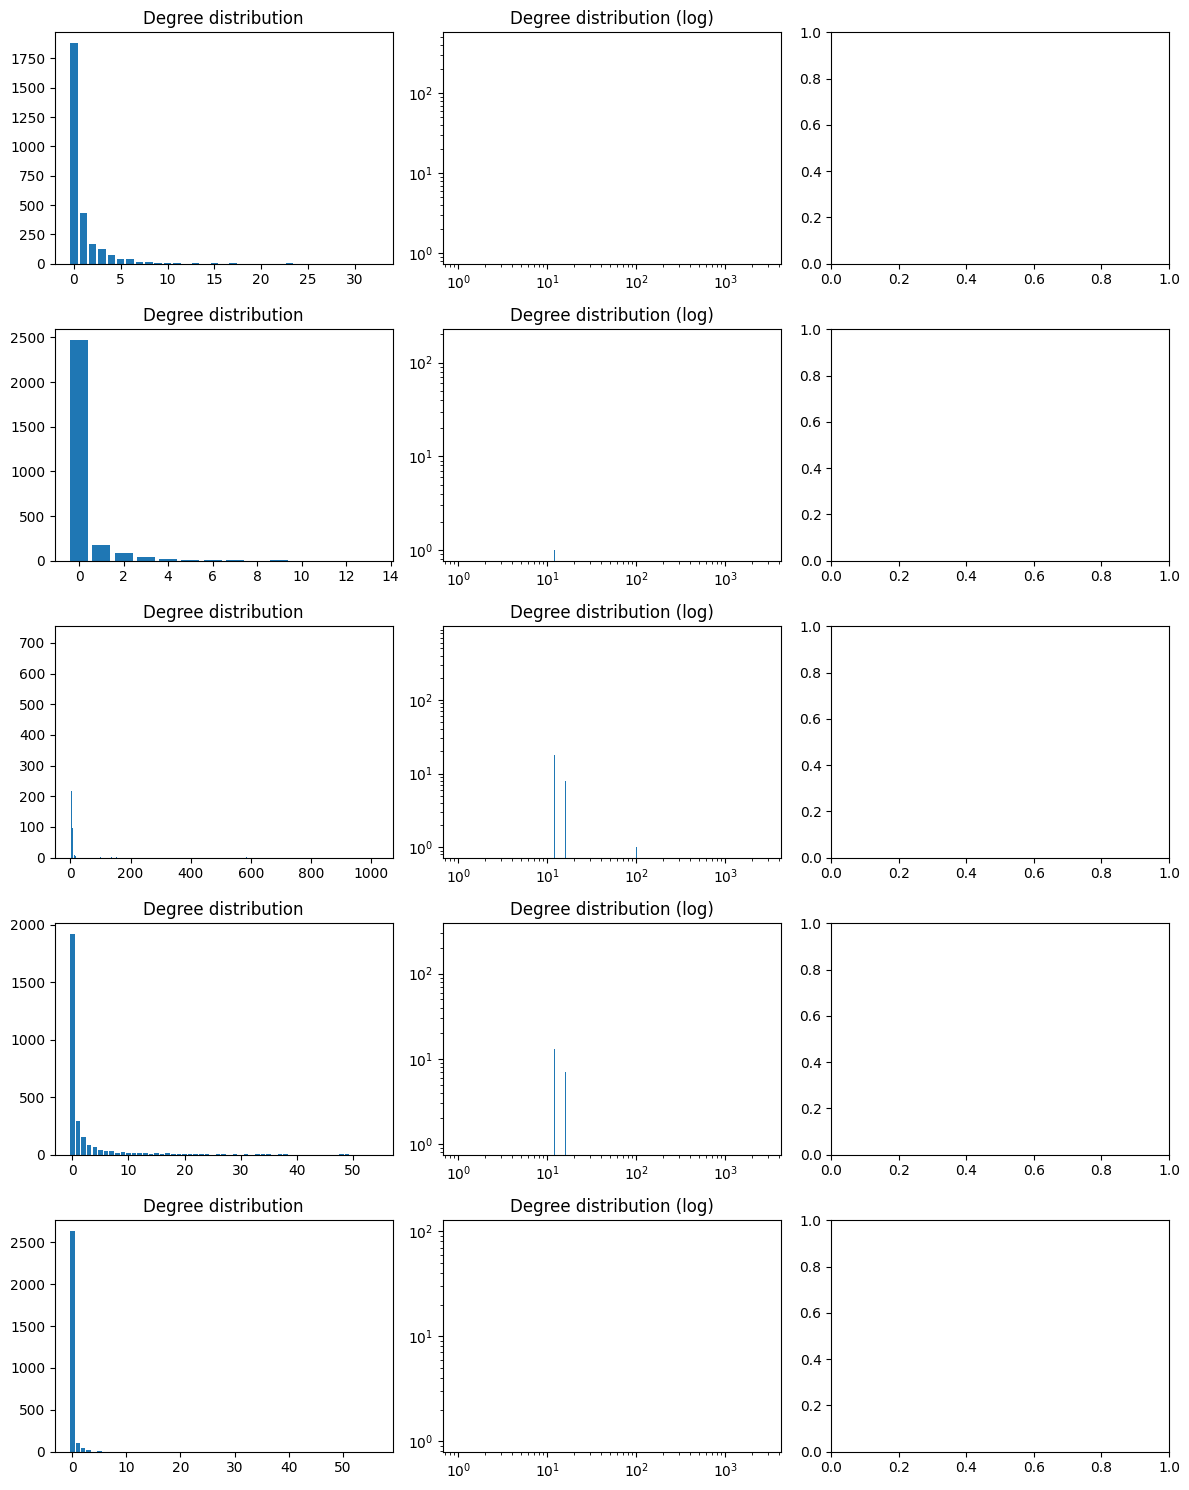

In [53]:
G = load_dataset(experiment)
graph_stats(G)

In [56]:
G, ap, gcc_size = remove_ap(G)
G, ap, len(ap), gcc_size

([<networkx.classes.graph.Graph at 0x1622f62fa60>,
 set(),
 0,
 2)